In [1]:
require 'pycall/import'
include PyCall::Import
require 'open-uri'

pyimport :pandas, as: :pd
pyimport :numpy, as: :np
pyblt = PyCall::builtins
Dict = PyCall::Dict
List = PyCall::List

<class 'list'>

In [2]:
 df_committers = pd.read_csv('ruby_committers_20191222.csv')

,user,author,is_github_user,addr
0,BurdetteLamar,Burdette Lamar,True,BurdetteLamar@Yahoo.com
1,Confusion,Ivo Wever,True,ivo.wever@gmail.com
2,Daniel-Berger,Daniel Berger,True,"dberger@redhat.com,djberg96@gmail.com"
3,DarkDimius,Dmitry Petrashko,True,dark@d-d.me
4,Empact,Ben Woosley,True,ben.woosley@gmail.com
...,...,...,...,...
215,yuki24,Yuki Nishijima,True,yk.nishijima@gmail.com
216,znz,Kazuhiro NISHIYAMA,True,"kazu@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,zn@m..."
217,zsombor,zsombor,True,zsombor@b2dd03c8-39d4-4d8f-98ff-823fe69b080e
218,zverok,zverok,True,zverok.offline@gmail.com


In [3]:
def read_committers_log(file)
    committers = File.read(file).split("\n").map do |e|
        commits, id = e.split("\t")
        user, addr = id.split(" <")
        [commits.to_i, user, addr.chop]
    end
    pd.DataFrame.new(data: committers, columns:[:commits, :author, :addr])
end

def add_rank(df_committers)
    df_all = read_committers_log("ruby_committers.log")
    commits = df_all[:commits].tolist
    addr = df_all[:addr].tolist
    committers = Hash.new(0)
    commits.zip(addr).each do |commits, addr|
        addr_replaced = addr.gsub('+', '.') 
        user = df_committers[proc {|df| df.addr.str.contains(addr_replaced)}].user.tolist.first
        if user
            committers[user] += commits
        else
            p addr unless addr.start_with?('(no author)')
        end
    end
        
    users = df_committers.user.tolist.to_a    
    rank_list = users.map do |user|
        committers.fetch(user, 0)
    end.map do |commits|
        if commits >= 10000
            "SS"
        elsif commits >= 1000
            "S"
        elsif commits >= 100
            "A"
        elsif commits >= 10
            "B"
        else
            "C"
        end 
    end
    df_committers[:rank] = rank_list
    df_committers
end

add_rank(df_committers)

df_committers

,user,author,is_github_user,addr,rank
0,BurdetteLamar,Burdette Lamar,True,BurdetteLamar@Yahoo.com,C
1,Confusion,Ivo Wever,True,ivo.wever@gmail.com,C
2,Daniel-Berger,Daniel Berger,True,"dberger@redhat.com,djberg96@gmail.com",C
3,DarkDimius,Dmitry Petrashko,True,dark@d-d.me,C
4,Empact,Ben Woosley,True,ben.woosley@gmail.com,C
...,...,...,...,...,...
215,yuki24,Yuki Nishijima,True,yk.nishijima@gmail.com,C
216,znz,Kazuhiro NISHIYAMA,True,"kazu@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,zn@m...",S
217,zsombor,zsombor,True,zsombor@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,C
218,zverok,zverok,True,zverok.offline@gmail.com,B


In [5]:
years = (1998..2019)
activity_type = 'trend'

commits_by_years = years.map do |year|
    df_year = read_committers_log("#{activity_type}/#{year}.log")
    commits = df_year[:commits].tolist
    addr = df_year[:addr].tolist
    commits_by_year = Hash.new(0)
    commits.zip(addr).each do |commits, addr|
        addr_replaced = addr.gsub('+', '.')
        user = df_committers[proc {|df| df.addr.str.contains(addr_replaced)}].user.tolist.first
        if user
            commits_by_year[user] += commits
        else
            p addr unless addr.start_with?('(no author)')
        end
    end
    commits_by_year
end
nil

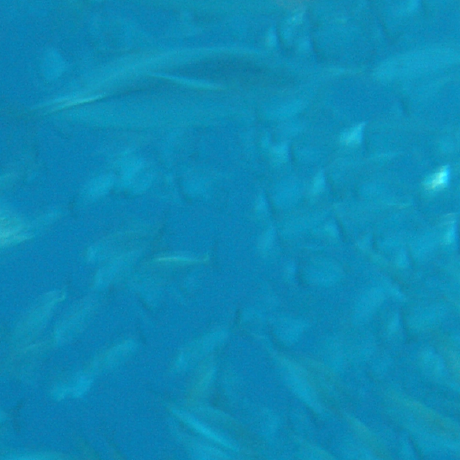

#<CZTop::Socket::PUB:0x563fa1436250 last_endpoint="tcp://127.0.0.1:53583">

In [6]:
open("https://github.com/hinastory.png") do |io|
    png = io.read
    IRuby.display png, mime: 'image/png'
end

In [7]:
label_add = proc do |df|
    df.user.tolist.zip(df.author.tolist).map do |user, author|
        user == author ? user : "#{user} (#{author})"
    end
end

image_add = proc do |df|
    df.user.tolist.zip(df.is_github_user.tolist).map do |user, is_github_user|
        is_github_user ? "https://github.com/#{user}.png" : ''
    end
end

df_committers_added = df_committers.assign(label: label_add, image: image_add)

,user,author,is_github_user,addr,rank,label,image
0,BurdetteLamar,Burdette Lamar,True,BurdetteLamar@Yahoo.com,C,BurdetteLamar (Burdette Lamar),https://github.com/BurdetteLamar.png
1,Confusion,Ivo Wever,True,ivo.wever@gmail.com,C,Confusion (Ivo Wever),https://github.com/Confusion.png
2,Daniel-Berger,Daniel Berger,True,"dberger@redhat.com,djberg96@gmail.com",C,Daniel-Berger (Daniel Berger),https://github.com/Daniel-Berger.png
3,DarkDimius,Dmitry Petrashko,True,dark@d-d.me,C,DarkDimius (Dmitry Petrashko),https://github.com/DarkDimius.png
4,Empact,Ben Woosley,True,ben.woosley@gmail.com,C,Empact (Ben Woosley),https://github.com/Empact.png
...,...,...,...,...,...,...,...
215,yuki24,Yuki Nishijima,True,yk.nishijima@gmail.com,C,yuki24 (Yuki Nishijima),https://github.com/yuki24.png
216,znz,Kazuhiro NISHIYAMA,True,"kazu@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,zn@m...",S,znz (Kazuhiro NISHIYAMA),https://github.com/znz.png
217,zsombor,zsombor,True,zsombor@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,C,zsombor,https://github.com/zsombor.png
218,zverok,zverok,True,zverok.offline@gmail.com,B,zverok,https://github.com/zverok.png


In [8]:
df_development_activity = df_committers_added

users = df_development_activity.user.tolist.to_a
years.zip(commits_by_years).each do |year, commits_by_year|
    commits_list = users.map do |user|
        commits_by_year.fetch(user, 0)
    end
    df_development_activity[year] = commits_list
end
nil

In [9]:
df_development_activity

,user,author,is_github_user,addr,rank,label,image,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,BurdetteLamar,Burdette Lamar,True,BurdetteLamar@Yahoo.com,C,BurdetteLamar (Burdette Lamar),https://github.com/BurdetteLamar.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,Confusion,Ivo Wever,True,ivo.wever@gmail.com,C,Confusion (Ivo Wever),https://github.com/Confusion.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Daniel-Berger,Daniel Berger,True,"dberger@redhat.com,djberg96@gmail.com",C,Daniel-Berger (Daniel Berger),https://github.com/Daniel-Berger.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,DarkDimius,Dmitry Petrashko,True,dark@d-d.me,C,DarkDimius (Dmitry Petrashko),https://github.com/DarkDimius.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Empact,Ben Woosley,True,ben.woosley@gmail.com,C,Empact (Ben Woosley),https://github.com/Empact.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,yuki24,Yuki Nishijima,True,yk.nishijima@gmail.com,C,yuki24 (Yuki Nishijima),https://github.com/yuki24.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
216,znz,Kazuhiro NISHIYAMA,True,"kazu@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,zn@m...",S,znz (Kazuhiro NISHIYAMA),https://github.com/znz.png,0,0,0,0,0,0,0,0,0,0,55,32,59,51,94,135,92,123,144,155,192,268
217,zsombor,zsombor,True,zsombor@b2dd03c8-39d4-4d8f-98ff-823fe69b080e,C,zsombor,https://github.com/zsombor.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218,zverok,zverok,True,zverok.offline@gmail.com,B,zverok,https://github.com/zverok.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16


In [10]:
df_development_activity.to_csv("ruby_development_activity_#{activity_type}_1998-2019.csv", index: false)